# Memory Information

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.46GB
Available: 24.54GB
Used: 580.10MB
Percentage: 3.6%


In [4]:
! nvidia-smi

Sat Jun 19 05:09:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Module Imports

In [5]:
!git clone https://github.com/EVA6-Group-15/DLUtils.git ./DLUtils
!cp -r ./DLUtils/src/dlutils/ ./Utils
!rm -r DLUtils

Cloning into './DLUtils'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 248 (delta 106), reused 165 (delta 60), pack-reused 0
Receiving objects: 100% (248/248), 57.18 KiB | 11.44 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [6]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-qseppjfd
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-qseppjfd
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=05cce88826574bd734fe6f8ebaf35b373066ac17f2dae373d3da0d3633bdc999
  Stored in directory: /tmp/pip-ephem-wheel-cache-oq4q276t/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [7]:
from Utils.data.pytorch_data import GetData
from Utils.data.transformations import * #HELPER, generate_compose
from Utils.visualization import plot_inference, plotter

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

# Data

## Finding Data Stats

In [9]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")

LOADER_kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [10]:
cifar = GetData('CIFAR10')

In [11]:
train_data = cifar.build_data(train=True)
test_data = cifar.build_data(train=False)


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [12]:
loader = DataLoader(
    train_data,
    batch_size=1000,
    num_workers=1,
    shuffle=False
)

mean, std = plotter.data_stats(loader)

Train Statistics
Image Shape:  torch.Size([3, 32, 32])
 - mean: [tensor(0.4914), tensor(0.4822), tensor(0.4465)]
 - std: [tensor(0.2470), tensor(0.2434), tensor(0.2615)]


## Creating Augmentations for Data

In [13]:
album_help = HELPER()

In [14]:
album_help.functions()

use <object_name>.<function_name> to know more about each. Eg: <object_name>.Blur
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1. 'Blur' - Blur the Input Image using Rnadom Size Kernel.
2. 'CoarseDropout' - CoarseDropout of Rectangular Regions in the Image.
3. 'ColorJitter' - Randomly changes the brightness, contrast, and saturation of an Image.
4. 'Cutout' - CoarseDropout of the square regions in the Image.
5. 'Flip' - Flip the Image either horizontally, vertically or both horizontally and vertically.
6. 'HorizontalFlip' - Flip the Image horizontally around the y-axis
7. 'VerticalFlip' - Flip the Image vertically around the x-axis
8. 'GaussianBlur' - Blur the input Image using a Gaussian filter with a random kernel size.
9. 'ShiftScaleRotate' - Randomly apply affine transforms: translate, scale and rotate the input.
10. 'Normalize' - Normalization is applied by the formula: **img = (img - mean * max_pixel_value) / (std * max_pixel_value)**.
Note: T

In [15]:
album_help.ShiftScaleRotate

" {ShiftScaleRotate: {'shift_limit': 0.0625, 'scale_limit': 0.1, 'rotate_limit': 45, 'interpolation': 1, 'border_mode': 4, 'value': None, 'mask_value': None, 'shift_limit_x': None, 'shift_limit_y': None, 'always_apply': False, 'p': 0.5}, ... }"

In [16]:
album_help.HorizontalFlip

" {HorizontalFlip: {'always_apply': False, 'p': 0.5}, ... }"

In [17]:
album_help.CoarseDropout

" {CoarseDropout: {'max_holes': 8, 'max_height': 8, 'max_width': 8, 'min_holes': None, 'min_height': None, 'min_width': None, 'fill_value': 0, 'mask_fill_value': None, 'always_apply': False, 'p': 0.5}, ... }"

In [18]:
album_help.ToGray

" {ToGray: {'always_apply': False, 'p': 0.5}, ... }"

In [19]:
transformations = {
    'ShiftScaleRotate': {'shift_limit': 0.05, 'scale_limit': 0.1, 'rotate_limit': 7,},
    'HorizontalFlip': {},
    'CoarseDropout': {'max_holes': 1, 'max_height':16, 'max_width':16, 'min_holes': 1, 
                      'min_height':16, 'min_width':16, 'fill_value':[0.4914, 0.4822, 0.4465], 
                      'mask_fill_value': None},
    'ToGray': {}
}

In [20]:
train_trans = generate_compose(mean, std, **transformations) # Normalize and ToTensor by Default along with Transformations
test_trans = generate_compose(mean, std) # Normalize and ToTensor by Default. No other Transformations

In [21]:
train_data = cifar.build_data(train_trans, train=True)
test_data = cifar.build_data(test_trans, train=False)
train_loader = cifar.build_loader(train_data, 64, **LOADER_kwargs)
test_loader = cifar.build_loader(test_data, 64, **LOADER_kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
classes = train_data.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Training Data

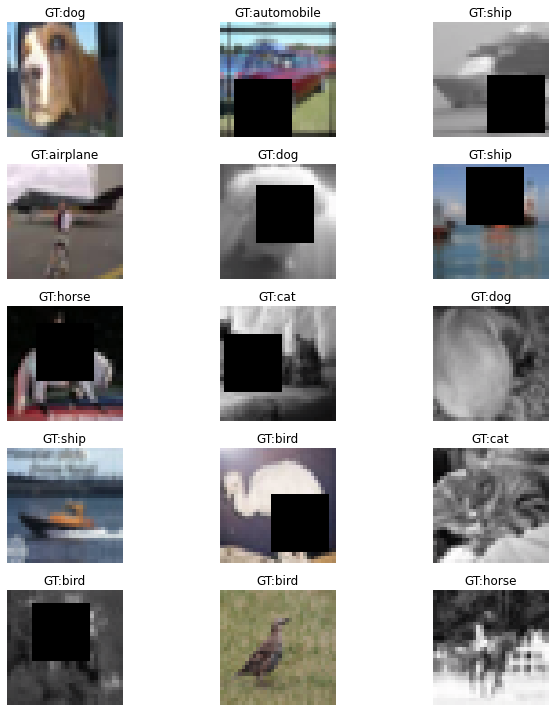

In [23]:
from Utils.visualization import plot_inference, plotter
plotter.plot_data_grid(train_loader, mean= mean, std= std, class_list=classes, ncol=3,nrow=5)

#### The CutOut is NOT black, it mean, but since we are UnNormaziling the Images before plotting, the CutOut values changes from mean to black

### Test Data

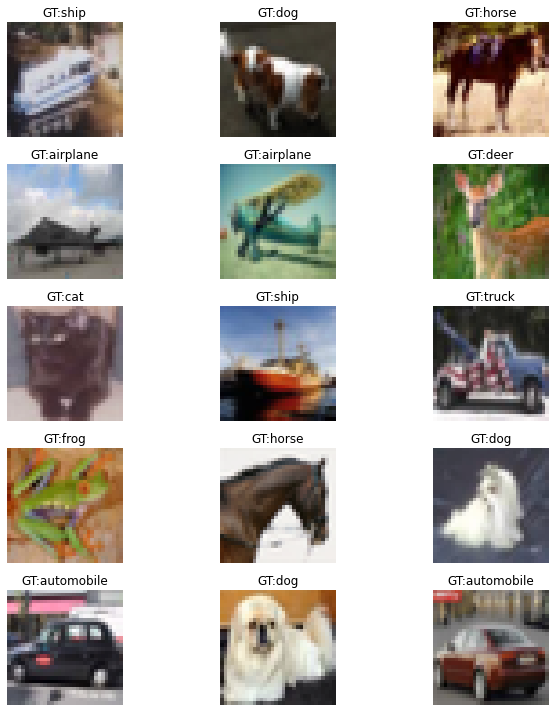

In [24]:
plotter.plot_data_grid(test_loader, mean= mean, std= std, class_list=classes, ncol=3,nrow=5)

# Model

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            # 32x32x3 -> 32x32x32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            # 32x32x32 -> 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, groups=32, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            # 32x32x32 -> 16x16x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
        )


        self.layer2 =  nn.Sequential(
            # 16x16x32 -> 16x16x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, groups=32, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            # 32x32x32 -> 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, groups=32, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            # 32x32x32 -> 16x16x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
        )

        self.layer3 =  nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, groups=32, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            # 32x32x32 -> 32x32x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, groups=32, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            # 32x32x32 -> 16x16x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
        )

        self.layer4 =  nn.Sequential(
            # 4x4x32 -> 4x4x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, groups=32, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            # 4x4x32 -> 4x4x32
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, groups=32, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            # # 4x4x32 -> 1x1x32
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1),
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        x = x.view(-1,10)

        return F.log_softmax(x, dim=1)

In [26]:
model = Net().to(DEVICE)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             288
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 16, 16]           9,216
       BatchNorm2d-8           [-1, 32, 16, 16]              64
              ReLU-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]             288
      BatchNorm2d-11           [-1, 32, 16, 16]              64
             ReLU-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]             288
      BatchNorm2d-14           [-1, 32,

In [27]:
from Utils.features.runner import run

In [28]:
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
ai = run.Run(model, train_loader, test_loader, 500, DEVICE, optimizer)
ai()

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1


loss=1.1285301446914673 batch_id=781: 100%|██████████| 782/782 [00:14<00:00, 53.96it/s]


TRAIN set: Average loss: 1.8664, Train Accuracy: 30.40% | TEST set: Average loss: 1.4392, Test Accuracy: 46.51%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 1.4738, Train Accuracy: 46.22% | TEST set: Average loss: 1.1970, Test Accuracy: 56.28%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 1.3193, Train Accuracy: 52.32% | TEST set: Average loss: 1.1090, Test Accuracy: 59.98%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 1.2126, Train Accuracy: 56.88% | TEST set: Average loss: 0.9938, Test Accuracy: 64.87%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 1.1654, Train Accuracy: 58.38% | TEST set: Average loss: 0.9156, Test Accuracy: 67.77%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 1.1204, Train Accuracy: 60.28% | TEST set: Average loss: 0.9235, Test Accur

In [29]:
print('Train Accuracy:', max(ai.metrics['train_accuracy']))
print('Test Accuracy:', max(ai.metrics['test_accuracy']))

Train Accuracy: 77.062
Test Accuracy: 82.47


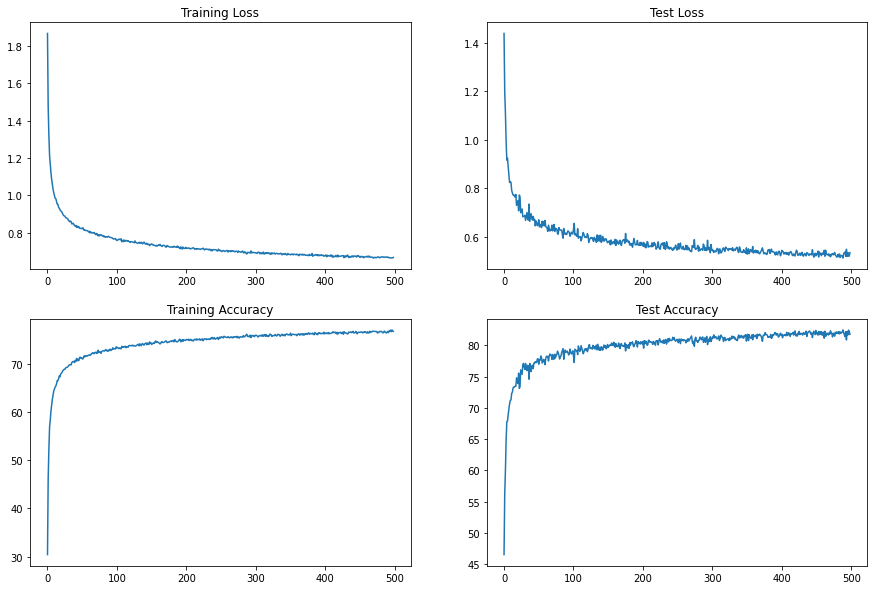

In [30]:
plotter.plot_loss_acc(ai.metrics['train_loss'], ai.metrics['train_accuracy'], ai.metrics['test_loss'], ai.metrics['test_accuracy'])

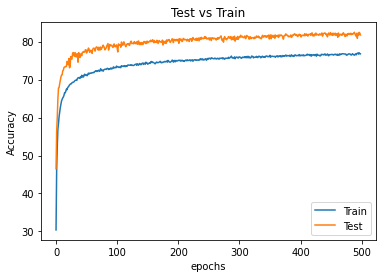

In [31]:
plotter.plot_combined([ai.metrics['train_accuracy'], ai.metrics['test_accuracy']])

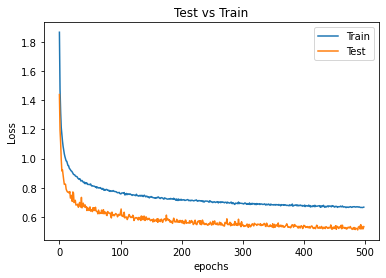

In [32]:
plotter.plot_combined([ai.metrics['train_loss'], ai.metrics['test_loss']], y_label='Loss')

In [33]:
results = plot_inference.Results(model, test_loader, DEVICE, mean, std, classes)

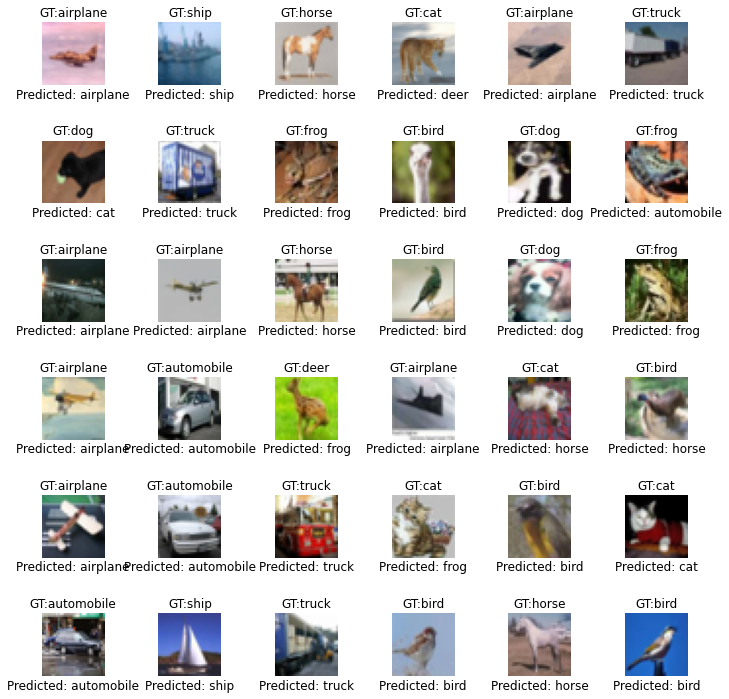

In [34]:
results.plot_batch(6,6)

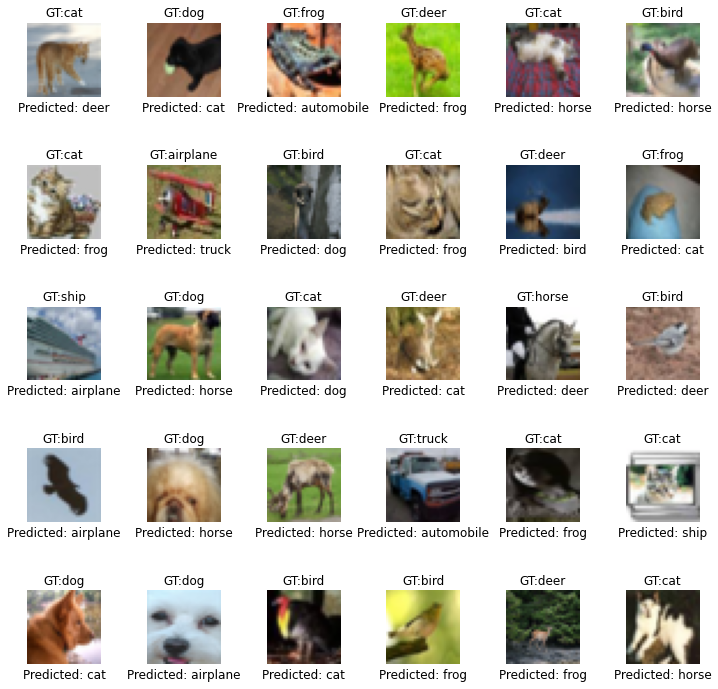

In [35]:
results.plot_incorrect(5,6)

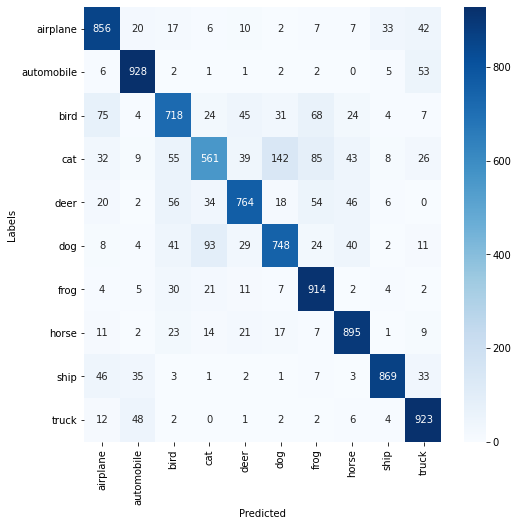

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class cat is 56.10
Accuracy of class bird is 71.80
Accuracy of class dog is 74.80
Accuracy of class deer is 76.40
Accuracy of class airplane is 85.60
Accuracy of class ship is 86.90
Accuracy of class horse is 89.50
Accuracy of class frog is 91.40
Accuracy of class truck is 92.30
Accuracy of class automobile is 92.80


In [36]:
results.class_accuracy()